In [1]:
import os
import pandas as pd 
import numpy as np 
import scipy as scp
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
import matplotlib.pyplot as plt

#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= ""

# 📂DATA : 3 Classes

In [3]:
fold = 1

In [4]:
path = "/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_TrainML_3Fold_split3class.csv"
data_feature = pd.read_csv(path)
print(data_feature.shape)
print("-"*100)
print(f"All Fold : {set(data_feature.fold)}")
## Split Train data Set
feature_train = data_feature[data_feature["fold"]!=fold].reset_index(drop=True)
print(f"Train Set : Fold ==> {set(feature_train.fold)}")
print("Train = ", feature_train.shape)
## Split Valid data Set
feature_test = data_feature[data_feature["fold"]==fold].reset_index(drop=True)
print(f"Valiadtion Set : Fold ==> {set(feature_test.fold)}")
print("Validation = ", feature_test.shape)
## Print DataFrame
feature_train.head()

(51, 9)
----------------------------------------------------------------------------------------------------
All Fold : {1, 2, 3}
Train Set : Fold ==> {2, 3}
Train =  (35, 9)
Valiadtion Set : Fold ==> {1}
Validation =  (16, 9)


,Unnamed: 0,Code,classes,subclass,fold,classes_binary,MCV,MCH,Hb
0,16,HN22,HN,No_Splenectomy,2,1.0,65.6,20.2,7.5
1,17,HN21,HN,No_Splenectomy,2,1.0,64.8,19.7,6.5
2,18,HN20,HN,No_Splenectomy,2,1.0,69.5,20.5,6.1
3,19,NBL16,NBL,Normal,2,0.0,79.6,24.9,13.2
4,20,NBL21,NBL,Normal,2,0.0,74.9,23.9,14.5


In [7]:
X_train = feature_train[['MCV','MCH','Hb']]
y_train = feature_train["subclass"]
print(X_train.shape)
print(y_train.shape)
print(y_train[0])

(35, 3)
(35,)
No_Splenectomy


In [8]:
print(len(list(set(y_train))))
print(set(y_train))

3
{'Normal', 'No_Splenectomy', 'Splenectomy'}


## 🩸 Parameter: Decision Tree

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [10]:
Dtree = DecisionTreeClassifier(random_state=1)

params = {"splitter":["best","random"],
          'max_depth': np.linspace(1, 7, 7, endpoint=True),
          'min_samples_leaf':  np.linspace(0.1, 0.5, 5, endpoint=True),
          'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
          'criterion': ["gini", "entropy"]}

tuning_Dtree = GridSearchCV(estimator=Dtree, param_grid=params, cv=10, n_jobs=-1, verbose=1, scoring = "accuracy")

# fitting the model for grid search 
best_Dtree = tuning_Dtree.fit(X_train, y_train)

Fitting 10 folds for each of 1400 candidates, totalling 14000 fits


In [11]:
# view the results as a pandas DataFrame
best_Dtreedf = pd.DataFrame(best_Dtree.cv_results_)[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]
best_Dtreedf = best_Dtreedf.sort_values(by='rank_test_score', ascending=True)
best_Dtreedf = best_Dtreedf.reset_index(drop=True)
best_Dtreedf.head()

,rank_test_score,mean_test_score,std_test_score,params
0,1,0.8,0.230338,"{'criterion': 'gini', 'max_depth': 6.0, 'min_s..."
1,1,0.8,0.230338,"{'criterion': 'entropy', 'max_depth': 5.0, 'mi..."
2,1,0.8,0.230338,"{'criterion': 'gini', 'max_depth': 5.0, 'min_s..."
3,1,0.8,0.230338,"{'criterion': 'gini', 'max_depth': 7.0, 'min_s..."
4,1,0.8,0.230338,"{'criterion': 'gini', 'max_depth': 5.0, 'min_s..."


In [12]:
# examine the first result
print("**examine the first result","\n")

print(best_Dtree.cv_results_['params'][0])
print(best_Dtree.cv_results_['mean_test_score'][0])

# print the array of mean scores only
print("\n","**print the array of mean scores only","\n")

grid_mean_scores = best_Dtree.cv_results_['mean_test_score']
print(grid_mean_scores)

# examine the best model
print("\n","**examine the best model","\n")

print(best_Dtree.best_score_)
print(best_Dtree.best_params_)
print(best_Dtree.best_estimator_)

**examine the first result 

{'criterion': 'gini', 'max_depth': 1.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
0.6333333333333334

 **print the array of mean scores only 

[0.63333333 0.63333333 0.63333333 ... 0.29166667 0.425      0.29166667]

 **examine the best model 

0.8
{'criterion': 'gini', 'max_depth': 2.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
DecisionTreeClassifier(max_depth=2.0, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=1)


In [13]:
#Print the tured parameters and score
print("Tuned Decision Tree Parameters: {}".format(best_Dtree.best_params_))
print("Best score is {}".format(best_Dtree.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 2.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
Best score is 0.8


In [14]:
best_params_ =  best_Dtree.best_params_
criterion_ = best_params_['criterion'] 
max_depth_ = best_params_['max_depth'] 
min_samples_leaf_ = best_params_['min_samples_leaf']   
min_samples_split_ = best_params_['min_samples_split']
splitter_ = best_params_['splitter']

> ## 🚀 Fit Model and setting parameters

In [15]:
## **- train Fit Model XGBOOST
DtreeClassifier = DecisionTreeClassifier(criterion=criterion_, max_depth=max_depth_, min_samples_leaf=min_samples_leaf_,
                                 min_samples_split=min_samples_split_, splitter=splitter_)
DtreeClassifierModel = DtreeClassifier.fit(X_train, y_train) # train XGBOOST model
DtreeClassifierModel

DecisionTreeClassifier(max_depth=2.0, min_samples_leaf=0.1,
                       min_samples_split=0.1)

In [16]:
### Testing Check Parameter
print(DtreeClassifierModel.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2.0, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


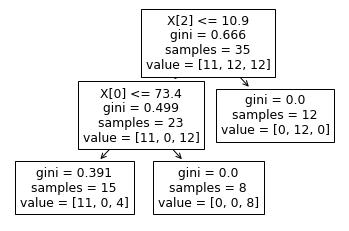

In [17]:
from sklearn import tree
tree.plot_tree(DtreeClassifierModel);

> ## #️⃣ Save model

In [18]:
numclass = 3

In [19]:
#Save Model
import os
import pickle
import imageio

save_pathimg = f'/media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/_{numclass}Classes/fold{fold}'
##**Mkdir Directory 
os.makedirs(save_pathimg, exist_ok=True)     
filename = f"DtreeClassifier_Model_Blood{numclass}Class_fold{fold}.pkl"
Model2Save =  f"{save_pathimg}/{filename}"
print(f"[INFO]: Done!! Save Model as : {Model2Save}")

with open(Model2Save, 'wb') as file:
    pickle.dump(DtreeClassifierModel, file)

[INFO]: Done!! Save Model as : /media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/_3Classes/fold1/DtreeClassifier_Model_Blood3Class_fold1.pkl
